In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


# Second Objective

### Time data based qualitative observations

In this section our goal is look at aggregated time data from the baseline processing to see if any correlations (clusters) can be found. We will do this using KMeans. This could give us some insights into meta information about users.

In [3]:
train = pd.read_csv('../DSB2019/data-science-bowl-2019/train.csv')

In [4]:
hasAssessmentIds = train[train["type"] == "Assessment"].loc[:,'installation_id'].drop_duplicates()
useful_train = pd.merge(train, hasAssessmentIds, on="installation_id", how="inner")
del train
train_sample = useful_train.sample(10000)

Let's define a function to get time features with.

In [5]:
def extract_time_features(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date
    df['month'] = df['timestamp'].dt.month
    df['hour'] = df['timestamp'].dt.hour
    df['year'] = df['timestamp'].dt.year
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    df['weekofyear'] = df['timestamp'].dt.weekofyear
    df['dayofyear'] = df['timestamp'].dt.dayofyear
    df['quarter'] = df['timestamp'].dt.quarter
    
    return df

In [6]:
timeTrain = extract_time_features(train_sample)
timeTrain.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,month,hour,year,dayofweek,weekofyear,dayofyear,quarter
5966892,6bf9e3e1,0d6c034852d557d5,2019-08-25 21:57:15.619000+00:00,"{""source"":""scale"",""has_toy"":false,""bowl_id"":1,...",b69d5756,17,4040,36327,Happy Camel,Game,CRYSTALCAVES,2019-08-25,8,21,2019,6,34,237,3
379367,e080a381,f1ba7b2718d2831b,2019-08-06 18:56:01.398000+00:00,"{""scale_weights"":1,""target_weight"":3,""table_we...",0b6d68e5,131,4090,232777,Pan Balance,Game,CRYSTALCAVES,2019-08-06,8,18,2019,1,32,218,3
4392771,49ed92e9,43f726a91b643cae,2019-09-13 10:33:21.243000+00:00,"{""description"":""Looks like there's no water le...",85099eda,55,3010,91230,Watering Hole (Activity),Activity,MAGMAPEAK,2019-09-13,9,10,2019,4,37,256,3
1413637,0a08139c,cb7dfdc98a8f7eef,2019-08-02 17:49:28.039000+00:00,"{""description"":""Four!"",""identifier"":""sid_4"",""m...",2cb958cf,45,3010,23776,Bug Measurer (Activity),Activity,TREETOPCITY,2019-08-02,8,17,2019,4,31,214,3
1031219,1325467d,af1bccb7f75295e2,2019-08-10 00:45:55.066000+00:00,"{""coordinates"":{""x"":812,""y"":231,""stage_width"":...",1f71eb61,76,4070,50354,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-10,8,0,2019,5,32,222,3


In [7]:
timeTrain.shape

(10000, 19)

In [6]:
# plotting based on https://www.kaggle.com/gpreda/2019-data-science-bowl-eda
def plot_count(feature, title, df, size=1):
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(df))
    g = sns.countplot(df[feature], order = df[feature].value_counts().index[:20], palette='Set3')
    g.set_title("Distribution of {}".format(title))
    if(size > 2):
        plt.xticks(rotation=90, size=8)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()  

Next, we'll plot the distributions of the observations in time.

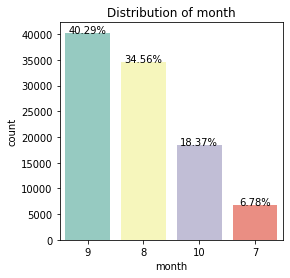

In [26]:
plot_count('month', 'month', timeTrain)

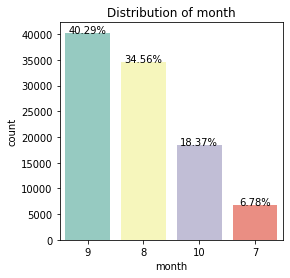

In [27]:
plot_count('month', 'month', timeTrain)

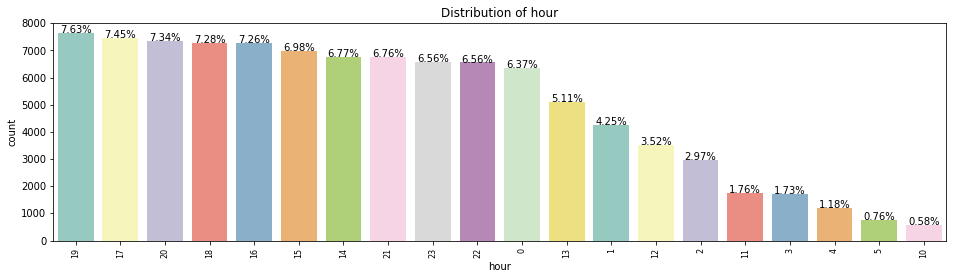

In [28]:
plot_count('hour', 'hour', timeTrain, 4)

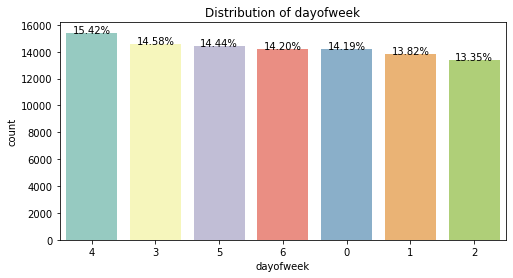

In [29]:
plot_count('dayofweek', 'dayofweek', timeTrain, 2)

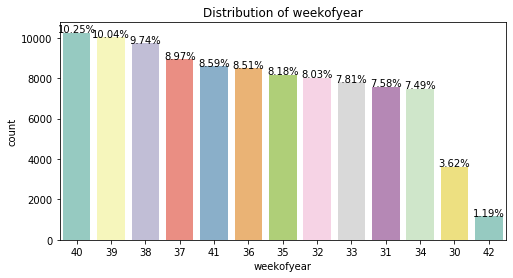

In [30]:
plot_count('weekofyear', 'weekofyear', timeTrain, 2)

Finally, let's explore some clustering based on the simple features.

In [8]:
# average time since user (id) last played
# average game time

def timeAvgs(singleIdData):

    singleIdData.sort_values('timestamp')
    singleIdData['lastPlay_time'] = singleIdData['timestamp'].shift(periods=1)
    singleIdData['time_since_lastPlay'] = (singleIdData['timestamp'] - singleIdData['lastPlay_time'])
    singleIdData['time_since_lastPlay'] = singleIdData['time_since_lastPlay']/np.timedelta64(1, 's')
    
    return singleIdData

In [9]:
timeTrain_ext = timeTrain.groupby('installation_id').apply(timeAvgs)
timeTrain_ext.fillna(0, inplace=True)
timeTrain_ext

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,...,date,month,hour,year,dayofweek,weekofyear,dayofyear,quarter,lastPlay_time,time_since_lastPlay
5966892,6bf9e3e1,0d6c034852d557d5,2019-08-25 21:57:15.619000+00:00,"{""source"":""scale"",""has_toy"":false,""bowl_id"":1,...",b69d5756,17,4040,36327,Happy Camel,Game,...,2019-08-25,8,21,2019,6,34,237,3,0,0.000
379367,e080a381,f1ba7b2718d2831b,2019-08-06 18:56:01.398000+00:00,"{""scale_weights"":1,""target_weight"":3,""table_we...",0b6d68e5,131,4090,232777,Pan Balance,Game,...,2019-08-06,8,18,2019,1,32,218,3,0,0.000
4392771,49ed92e9,43f726a91b643cae,2019-09-13 10:33:21.243000+00:00,"{""description"":""Looks like there's no water le...",85099eda,55,3010,91230,Watering Hole (Activity),Activity,...,2019-09-13,9,10,2019,4,37,256,3,0,0.000
1413637,0a08139c,cb7dfdc98a8f7eef,2019-08-02 17:49:28.039000+00:00,"{""description"":""Four!"",""identifier"":""sid_4"",""m...",2cb958cf,45,3010,23776,Bug Measurer (Activity),Activity,...,2019-08-02,8,17,2019,4,31,214,3,0,0.000
1031219,1325467d,af1bccb7f75295e2,2019-08-10 00:45:55.066000+00:00,"{""coordinates"":{""x"":812,""y"":231,""stage_width"":...",1f71eb61,76,4070,50354,Sandcastle Builder (Activity),Activity,...,2019-08-10,8,0,2019,5,32,222,3,0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4603116,5154fc30,44c688fa447ffd57,2019-08-26 13:26:20.726000+00:00,"{""description"":""1"",""identifier"":""count1"",""medi...",8b384f5c,80,3010,74902,Crystals Rule,Game,...,2019-08-26,8,13,2019,0,35,238,3,2019-08-27 21:28:30.342000+00:00,-115329.616
3488552,c1cac9a2,6eedf903c152e2db,2019-08-05 15:48:15.642000+00:00,"{""movie_id"":""scrubadub_outro"",""duration"":13900...",69ec51b9,77,2081,60898,Scrub-A-Dub,Game,...,2019-08-05,8,15,2019,0,32,217,3,2019-08-02 16:28:40.476000+00:00,256775.166
5116308,884228c8,33b2a7db758a20a2,2019-09-02 17:25:25.191000+00:00,"{""coordinates"":{""x"":401,""y"":644,""stage_width"":...",9cefacd0,80,4070,67058,Fireworks (Activity),Activity,...,2019-09-02,9,17,2019,0,36,245,3,2019-08-27 03:56:14.286000+00:00,566950.905
7427685,c952eb01,3c489284a62ea16f,2019-08-06 23:01:37.938000+00:00,"{""coordinates"":{""x"":488,""y"":443,""stage_width"":...",e4c57aab,7,4070,10508,Watering Hole (Activity),Activity,...,2019-08-06,8,23,2019,1,32,218,3,2019-08-05 21:13:41.267000+00:00,92876.671


In [10]:
from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer


#extract time related features only
timeOnly = timeTrain_ext[['time_since_lastPlay', 'game_time', 'hour']]

timeOnly_dict = timeOnly.to_dict(orient='records')

vec = DictVectorizer(sparse=False)
vec.fit(timeOnly_dict)

timeOnly = vec.transform(timeOnly_dict)

# Standardization
scaler = StandardScaler()
scaler.fit(timeOnly)
timeOnly = scaler.transform(timeOnly)

# use the same number of clusters as their are accuracy groups
model = KMeans(n_clusters=4)
model.fit(timeOnly)

centroids = model.cluster_centers_
clusters = model.labels_

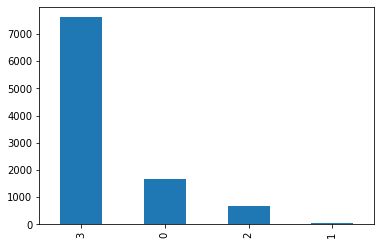

In [11]:
clusterDf = pd.DataFrame({'accuracy' : clusters})
clusterDf.accuracy.value_counts().plot.bar()

In [12]:
timeOnly

array([[-2.30917116e-01,  9.10510764e-01, -5.44524905e-04],
       [ 1.41564570e-01,  4.72989574e-01, -5.44524905e-04],
       [-1.26817539e-01, -6.93733598e-01, -5.44524905e-04],
       ...,
       [-1.72649187e-01,  3.27149178e-01,  4.69342171e-01],
       [-2.79871581e-01,  1.20219156e+00,  7.64312973e-02],
       [ 2.26805900e-01,  1.05635116e+00, -5.25348221e-04]])

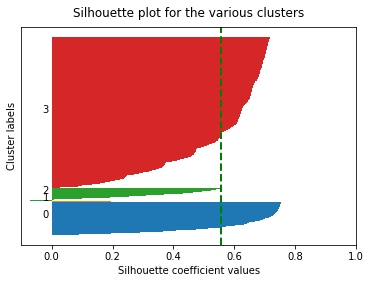

In [14]:
# Build a silhouette plot to represent the distance between clusters
from sklearn.metrics import silhouette_samples, silhouette_score

# Get silhouette samples
silhouette_vals = silhouette_samples(timeOnly, clusters)

# Silhouette plot
y_lower, y_upper = 0, 0
for i, cluster in enumerate(np.unique(clusters)):
    cluster_silhouette_vals = silhouette_vals[clusters == cluster]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)
    plt.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
    plt.text(-0.03, (y_lower + y_upper) / 2, str(i))
    y_lower += len(cluster_silhouette_vals)

# Get the average silhouette score and plot it
avg_score = np.mean(silhouette_vals)
plt.axvline(avg_score, linestyle='--', linewidth=2, color='green')
plt.yticks([])
plt.xlim([-0.1, 1])
plt.xlabel('Silhouette coefficient values')
plt.ylabel('Cluster labels')
plt.title('Silhouette plot for the various clusters', y=1.02);

### Conclusion

This time data actually looks quite correlated to accuracy groups, with 3 being the most common and 0 the next, with very few 1s and 2s. The silhouette plot tells us how clustered vs scattered the data is, with numbers closer to 1 being more clustered. Both the 3 and 0 groups are decently clustered meaning they are probably relevant based on the features. This is a fairly good result for unsupervised learning.